# SCADAA Report

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from exercise2 import DGM_Layer, Net_DGM
from exercise2 import FFN


## Exercise 1.1

In [76]:
class LQR:
    def __init__(self, H, M, sigma, alpha, alpha_s, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.alpha = alpha 
        self.alpha_s = alpha_s
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T
    

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (np.transpose(self.M)) @ S - self.C)
        return dS.flatten().detach().numpy()
 

    def solve_ricatti_ode(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        # S = [torch.tensor(sol.y[:, i].reshape((2, 2))) for i in range(len(sol.t))]
        S = torch.tensor(sol.y)

        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        # S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S[0, :])
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
        

    def markov_control(self, t_batch, x_batch):
        S = self.solve_ricatti_ode(t_batch).reshape(-1, 2, 2).float()
        x_batch = x_batch.view(x_batch.size(0), 2)
        
        a = - ((torch.inverse(self.D.float()) @ self.M.T) @ S) @ x_batch.unsqueeze(-1)

        return a.squeeze(-1)


    def value_function(self, t_batch, x_batch):
        S = self.solve_ricatti_ode(t_batch).reshape(-1, 2, 2).float()
        x_batch = x_batch.view(x_batch.size(0), 2, 1)

        # Compute the first term: x.transpose(S)x
        x_S_x = torch.matmul(torch.matmul(x_batch.transpose(1, 2), S), x_batch).squeeze()

        # Compute the integral term
        integral_term = 0
        for t, s in zip(t_batch, S):
            # Compute the trace term
            trace = (self.sigma @ self.sigma.T) @ s
            trace_term = torch.trace(trace.view(trace.size(0), -1))

            integral_term += trace_term * (self.T - t) / len(t_batch)

        # Compute the total value function: v(t, x) = x.transpose(S)x + trace_term
        v = x_S_x + integral_term

        return v


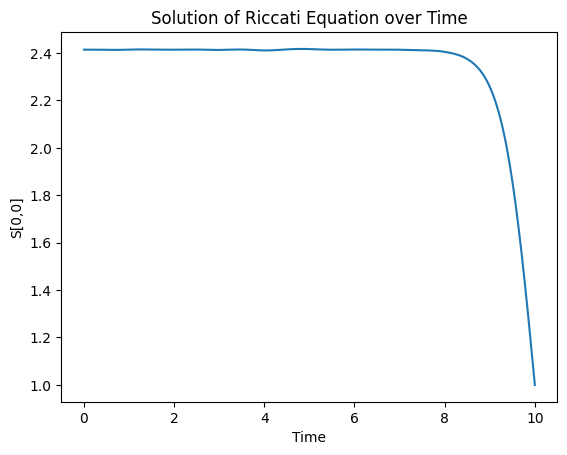

Optimal Markov Control:
tensor([[-7.2402, -2.4134],
        [ 0.0000,  0.0000],
        [ 4.8280, -2.4125]])
Value Function:
tensor([26.9513, 14.8844, -4.4247])


In [78]:
# Example Usage:
# Define problem matrices
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
alpha = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
alpha_s = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(10.0, dtype=torch.float32)

# Initialize LQRController
# controller = LQRController(H, M, D, C, R, T)

# Define time grid
time_grid = torch.linspace(0, T, 1000)

lqr_system = LQR(H, M, sigma, alpha, alpha_s, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)
t_points = np.linspace(0, T, 1000)[::-1]  
lqr_system.visualize_results(t_points, S_solution)

# Create sample input tensors
t_batch = torch.tensor([0.5, 0.8, 1.0], dtype=torch.float32)  # Sample time values
x_batch = torch.tensor([
    [[1.0, 2.0]],  # First example
    [[-1.0, 0.0]], # Second example
    [[3.0, -2.0]]  # Third example
], dtype=torch.float32)  # Sample spatial values

# Compute the markov control
markov_control = lqr_system.markov_control(t_batch, x_batch)

# Print the computed value function
print("Optimal Markov Control:")
print(markov_control)

# Compute the value function
value_func = lqr_system.value_function(t_batch, x_batch)

# Print the computed value function
print("Value Function:")
print(value_func)


In [ ]:
lqr_system = LQR(H, M, sigma, alpha, alpha_s, C, D, R, T)
v = lqr_system.value_function(time_grid)

In [ ]:
# Function to generate training data
def generate_training_data(T, num_samples):
    t = np.random.uniform(0, T, num_samples)
    x = np.random.uniform(-3, 3, (num_samples, 2))
    return t, x

# Main training function
def train_value_function(net, T, num_samples, num_epochs, lr):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        t, x = generate_training_data(T, num_samples)

        # this line needs to be fixed
        v = lqr_system.value_function(time_grid)

        input_data = torch.tensor(x, dtype=torch.float)
        output_data = torch.tensor(v, dtype=torch.float)

        outputs = net(input_data)
        loss = criterion(outputs, output_data)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Plot')
    plt.show()

# Set parameters
T = 1
num_samples = 1000
num_epochs = 100
lr = 0.001

# Initialize the neural network
net = DGM_Layer()

# Train the value function
train_value_function(net, T, num_samples, num_epochs, lr)

In [3]:

sizes = [input_size, 100, 100, output_size]  # Specify sizes of input, hidden, and output layers
ffn_model = FFN(sizes)